Импорт библиотек. Список библиотек находится в файле **requirements.txt**

In [107]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

import scipy.stats
from scipy import stats
from sklearn.ensemble import IsolationForest
from scipy.stats import norm, skew #for some statistics
from scipy.stats import normaltest

from IPython.display import Image
from IPython.core.display import HTML

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs



import os
import warnings
from factor_analyzer import FactorAnalyzer
from sklearn.multioutput import MultiOutputClassifier
warnings.filterwarnings('ignore')

## 1. Загрузка данных. 
Файл лежит в репозитории.

In [108]:
data = pd.read_csv('heart_attack_prediction_dataset.csv')
data = data.sample(frac=1)

data.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
8085,IJF8636,81,Female,161,116/76,45,1,1,1,0,...,0.060734,56774,28.065590,88,4,4,Italy,Europe,Southern Hemisphere,0
379,FVR1432,21,Male,370,162/73,61,1,1,1,1,...,11.455949,21679,24.616701,186,2,8,Argentina,South America,Southern Hemisphere,0
3202,RUD4688,71,Female,235,101/82,70,0,0,1,1,...,4.798462,111458,33.116089,614,7,6,India,Asia,Northern Hemisphere,1
5127,CFN2318,63,Male,132,147/70,104,1,1,1,0,...,9.700142,169423,19.057773,315,1,5,Argentina,South America,Southern Hemisphere,0
2073,NOS7437,90,Male,204,164/68,75,0,0,1,1,...,3.104164,94994,19.919144,585,0,5,South Africa,Africa,Southern Hemisphere,1


### Составим список выходных показателей, список показателей, которые стоит сразу исключить, а так же список которые являются входными

#### Список выходных показателей

In [109]:
key_columns = ['Heart Attack Risk']
print(key_columns)

['Heart Attack Risk']


#### Получим список параметров, представленных категорией, которые невозможно привести к виду вещественного числа. 
#### Далее данный список поместить в *Список показателей - исключений*

In [110]:
all_columns = data.columns
categorial_columns = []

for column in all_columns:
    value = data[column][0]
    try:
        value = float(value)
    except:
        categorial_columns.append(column)
print(categorial_columns)

['Patient ID', 'Sex', 'Blood Pressure', 'Diet', 'Country', 'Continent', 'Hemisphere']


#### Список показателей - исключений

In [111]:
exclude_columns = ["Patient ID", "Sex", "Blood Pressure", "Diet", "Country", "Continent", "Hemisphere"]
print(exclude_columns)

['Patient ID', 'Sex', 'Blood Pressure', 'Diet', 'Country', 'Continent', 'Hemisphere']


#### Список входных показателей

In [112]:
input_columns = [col for col in data.columns if col not in key_columns and col not in exclude_columns]
print(input_columns)

['Age', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day']


#### Данная функция принимает на вход датасет, список столбцов и тип данных возращаемого датасета. 
#### На выходе дает датасет из столбцов первоначального датасета, которые были указаны в переменной columns и приводит столбцы к типу out_type

In [113]:
def select_and_convert_columns(pd_data, columns, out_type):
    selected_data = pd_data[columns]
    selected_data = selected_data.astype(out_type)
    return selected_data

Приведем к типу вещественного числа (**float**) для удоства дальнейших вычислений

In [114]:
data1 = data.replace(',','.', regex=True)
# data = select_and_convert_columns(data, data.columns, str)
X = select_and_convert_columns(data, input_columns, float)
X.head()

,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day
8085,81.0,161.0,45.0,1.0,1.0,1.0,0.0,0.0,7.544272,0.0,1.0,7.0,0.060734,56774.0,28.065590,88.0,4.0,4.0
379,21.0,370.0,61.0,1.0,1.0,1.0,1.0,0.0,3.510426,0.0,1.0,7.0,11.455949,21679.0,24.616701,186.0,2.0,8.0
3202,71.0,235.0,70.0,0.0,0.0,1.0,1.0,0.0,18.704677,0.0,1.0,6.0,4.798462,111458.0,33.116089,614.0,7.0,6.0
5127,63.0,132.0,104.0,1.0,1.0,1.0,0.0,0.0,10.081130,0.0,0.0,9.0,9.700142,169423.0,19.057773,315.0,1.0,5.0
2073,90.0,204.0,75.0,0.0,0.0,1.0,1.0,0.0,9.174236,1.0,1.0,10.0,3.104164,94994.0,19.919144,585.0,0.0,5.0


In [115]:
Y.head()

,Heart Attack Risk
6024,0.0
3532,0.0
2670,1.0
2011,0.0
3582,1.0


Ниже представлена краткая информация о полученных данных

In [116]:
data.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
8085,IJF8636,81,Female,161,116/76,45,1,1,1,0,...,0.060734,56774,28.065590,88,4,4,Italy,Europe,Southern Hemisphere,0
379,FVR1432,21,Male,370,162/73,61,1,1,1,1,...,11.455949,21679,24.616701,186,2,8,Argentina,South America,Southern Hemisphere,0
3202,RUD4688,71,Female,235,101/82,70,0,0,1,1,...,4.798462,111458,33.116089,614,7,6,India,Asia,Northern Hemisphere,1
5127,CFN2318,63,Male,132,147/70,104,1,1,1,0,...,9.700142,169423,19.057773,315,1,5,Argentina,South America,Southern Hemisphere,0
2073,NOS7437,90,Male,204,164/68,75,0,0,1,1,...,3.104164,94994,19.919144,585,0,5,South Africa,Africa,Southern Hemisphere,1


Последние пять строк в данных:

In [117]:
data.tail()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
1613,TSQ4357,47,Male,158,153/105,40,0,0,1,0,...,2.484804,297858,18.303024,782,6,8,France,Europe,Northern Hemisphere,0
3593,YKU5234,23,Male,125,114/105,109,1,0,1,0,...,7.039077,192475,20.927820,132,6,7,United Kingdom,Europe,Northern Hemisphere,0
1230,SBF2762,80,Male,139,93/73,75,1,1,1,1,...,8.887439,161746,27.319421,750,0,7,China,Asia,Northern Hemisphere,0
6482,PMW2290,84,Male,174,167/109,52,1,0,1,1,...,0.363888,120208,18.252070,485,5,7,Germany,Europe,Northern Hemisphere,0
4777,TWS3025,36,Female,318,174/110,57,1,0,0,0,...,9.652376,75619,21.155181,127,7,10,South Africa,Africa,Southern Hemisphere,0


Ниже представлена информация о типах данных в датасете:

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8763 entries, 8085 to 4777
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                  

## 2. Предварительный анализ данных

Найдем пропуски в данных:


In [119]:
data.isnull().sum()

Patient ID                         0
Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64

Видим, что пропусков данных нет. Иначе во 2 колонке были бы ненулевые значения

Найдем аномальные значения.

**Прежде всего**, необходимо получить список столбцов (параметров) из нашего датасета. Это необходимо, так как на картинках подписи могут заехать друг на друга

In [120]:
columns = list(X.columns.values)
columns

['Age',
 'Cholesterol',
 'Heart Rate',
 'Diabetes',
 'Family History',
 'Smoking',
 'Obesity',
 'Alcohol Consumption',
 'Exercise Hours Per Week',
 'Previous Heart Problems',
 'Medication Use',
 'Stress Level',
 'Sedentary Hours Per Day',
 'Income',
 'BMI',
 'Triglycerides',
 'Physical Activity Days Per Week',
 'Sleep Hours Per Day']

Покажем все столбцы по отдельности по несколько штук штук

<Axes: >

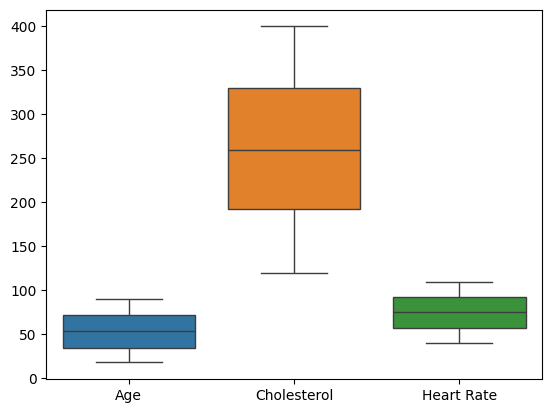

In [121]:
sns.boxplot(data=X.iloc[:, 0:3])

<Axes: >

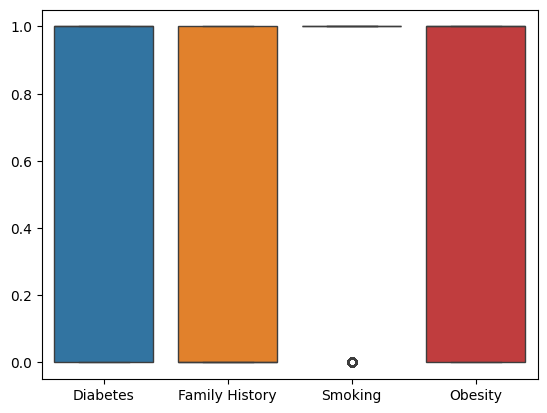

In [122]:
sns.boxplot(data=X.iloc[:, 3:7])

<Axes: >

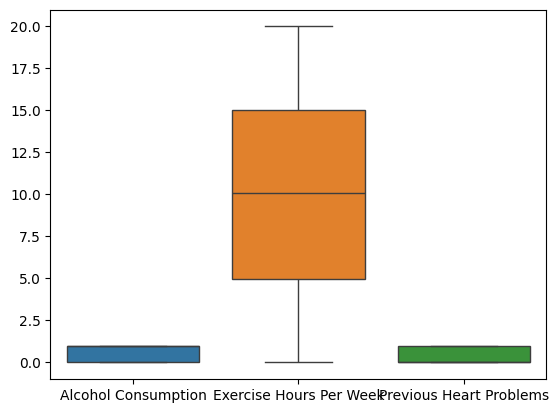

In [123]:
sns.boxplot(data=X.iloc[:, 7:10])

<Axes: >

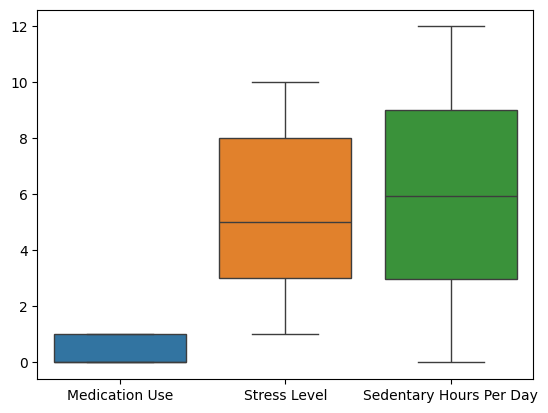

In [124]:
sns.boxplot(data=X.iloc[:, 10:13])

<Axes: >

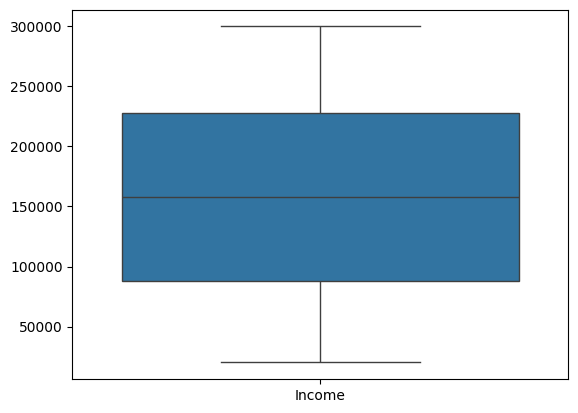

In [125]:
sns.boxplot(data=X.iloc[:, 13:14])

<Axes: >

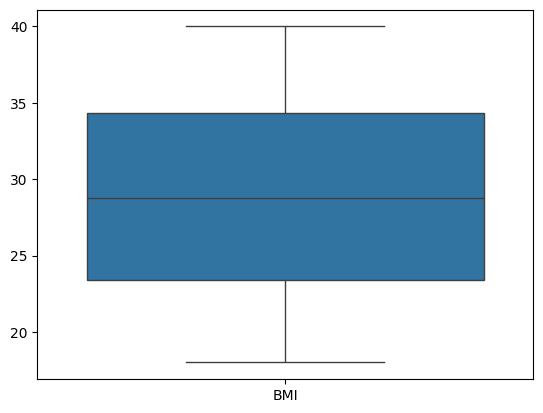

In [126]:
sns.boxplot(data=X.iloc[:, 14:15])

<Axes: >

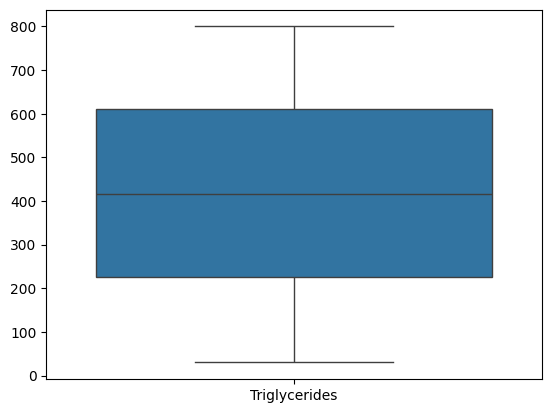

In [127]:
sns.boxplot(data=X.iloc[:, 15:16])

<Axes: >

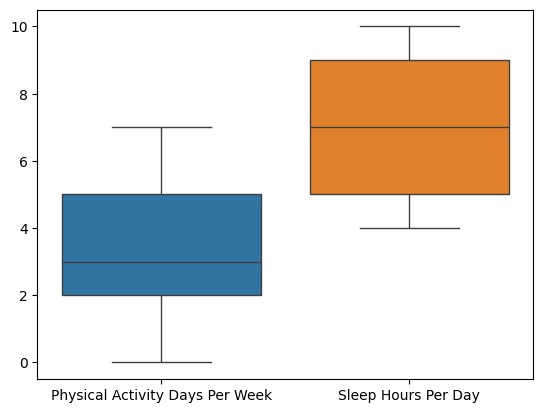

In [128]:
sns.boxplot(data=X.iloc[:, 16:18])

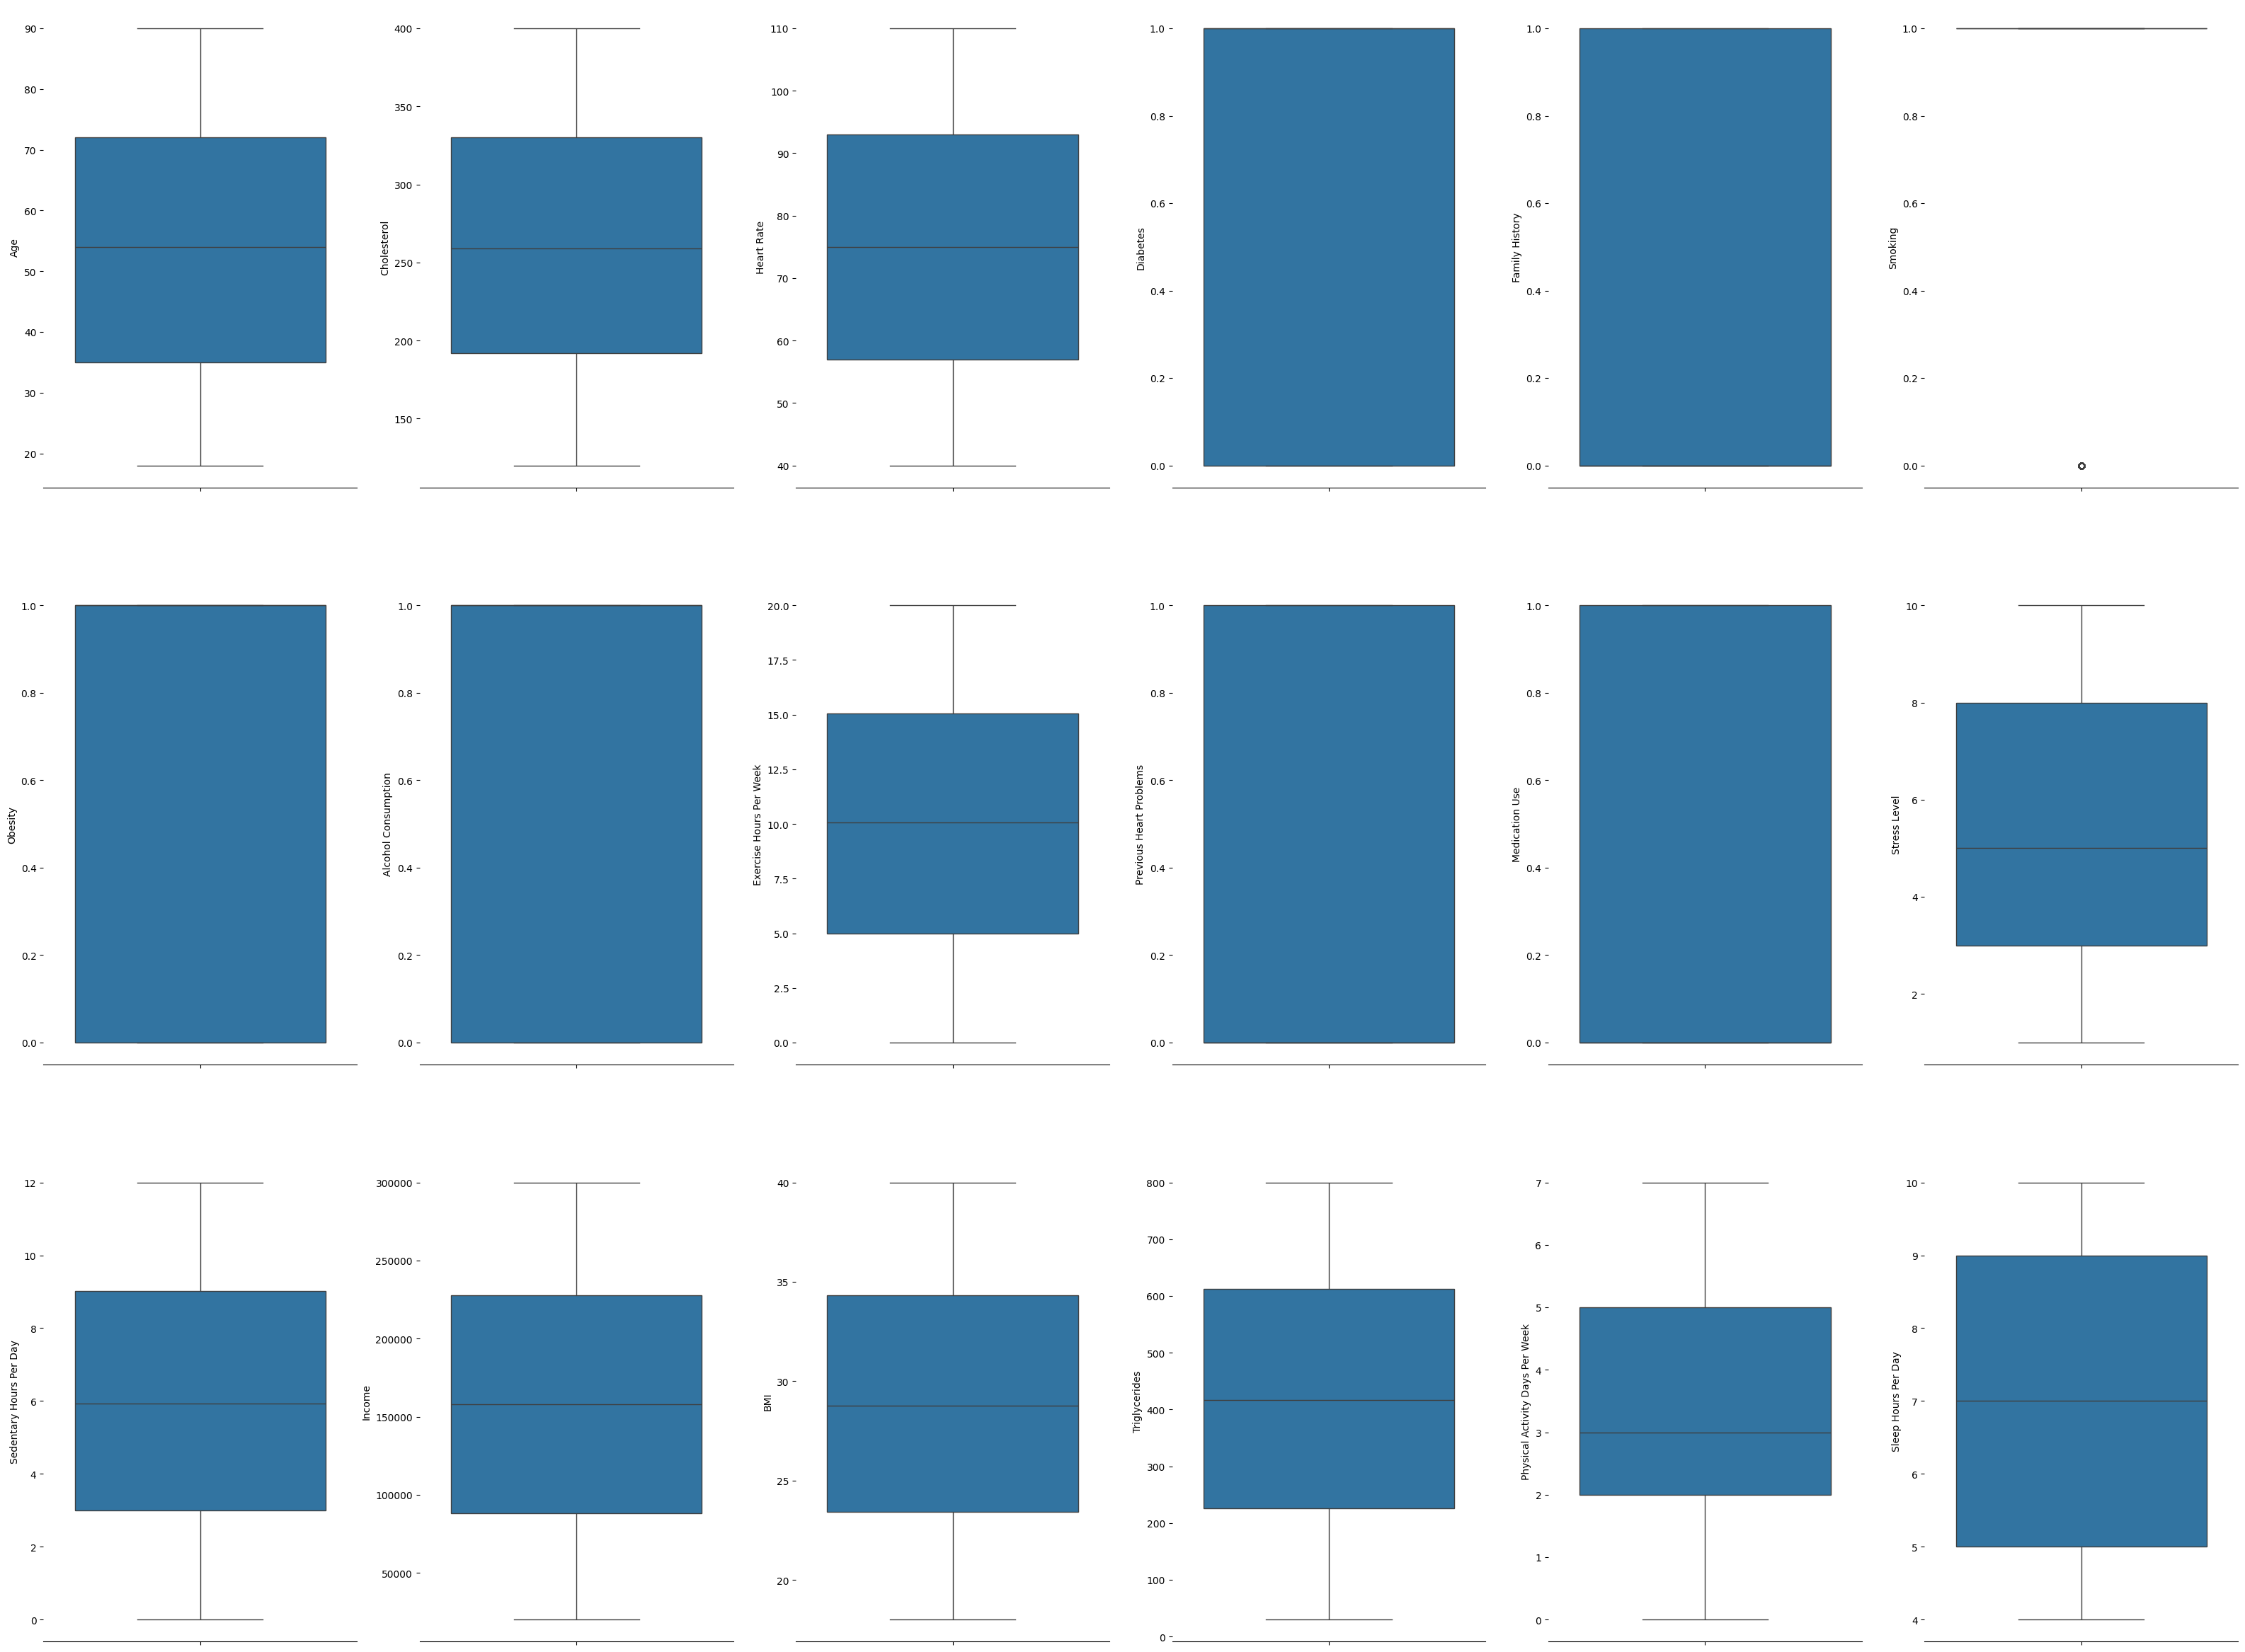

In [129]:
f, axes = plt.subplots(3, 6, figsize=(40, 30))
sns.despine(left=True)
for i in range(0, len(columns)):
    sns.boxplot(data = X[columns[i]], ax=axes[i//6, i%6])

Точками показаны выбросы. Интервалы отображают минимум и максимум, а прямоугольник медиану. 
В данных слишком выбросы показаны только на показателе **smoking** и обусловлены тем, что показатель представлен логическим значением и для него нет адекватной медианы

## 3.Вычисляем основные статистические характеристики


In [130]:
data.describe()

,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk
count,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000
mean,53.707977,259.877211,75.021682,0.652288,0.492982,0.896839,0.501426,0.598083,10.014284,0.495835,0.498345,5.469702,5.993690,158263.181901,28.891446,417.677051,3.489672,7.023508,0.358211
std,21.249509,80.863276,20.550948,0.476271,0.499979,0.304186,0.500026,0.490313,5.783745,0.500011,0.500026,2.859622,3.466359,80575.190806,6.319181,223.748137,2.282687,1.988473,0.479502
min,18.000000,120.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002442,0.000000,0.000000,1.000000,0.001263,20062.000000,18.002337,30.000000,0.000000,4.000000,0.000000
25%,35.000000,192.000000,57.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.981579,0.000000,0.000000,3.000000,2.998794,88310.000000,23.422985,225.500000,2.000000,5.000000,0.000000
50%,54.000000,259.000000,75.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.069559,0.000000,0.000000,5.000000,5.933622,157866.000000,28.768999,417.000000,3.000000,7.000000,0.000000
75%,72.000000,330.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.050018,1.000000,1.000000,8.000000,9.019124,227749.000000,34.324594,612.000000,5.000000,9.000000,1.000000
max,90.000000,400.000000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.998709,1.000000,1.000000,10.000000,11.999313,299954.000000,39.997211,800.000000,7.000000,10.000000,1.000000


Строка count - количество записей

mean - математическое ожидание (среднее)

std - среднее отклонение

min, max - минимальное и максимальное значение соответвственно

25%, 50%, 75% - отклонения от среднего

Вычисляем среднеквадратичное отклонение:

In [131]:
data.describe().iloc[2, :].pow(0.5)

Age                                  4.609719
Cholesterol                          8.992401
Heart Rate                           4.533315
Diabetes                             0.690124
Family History                       0.707092
Smoking                              0.551531
Obesity                              0.707126
Alcohol Consumption                  0.700224
Exercise Hours Per Week              2.404942
Previous Heart Problems              0.707115
Medication Use                       0.707125
Stress Level                         1.691042
Sedentary Hours Per Day              1.861816
Income                             283.857695
BMI                                  2.513798
Triglycerides                       14.958213
Physical Activity Days Per Week      1.510856
Sleep Hours Per Day                  1.410132
Heart Attack Risk                    0.692461
Name: std, dtype: float64

Поиск эксцессы, ассиметрии:

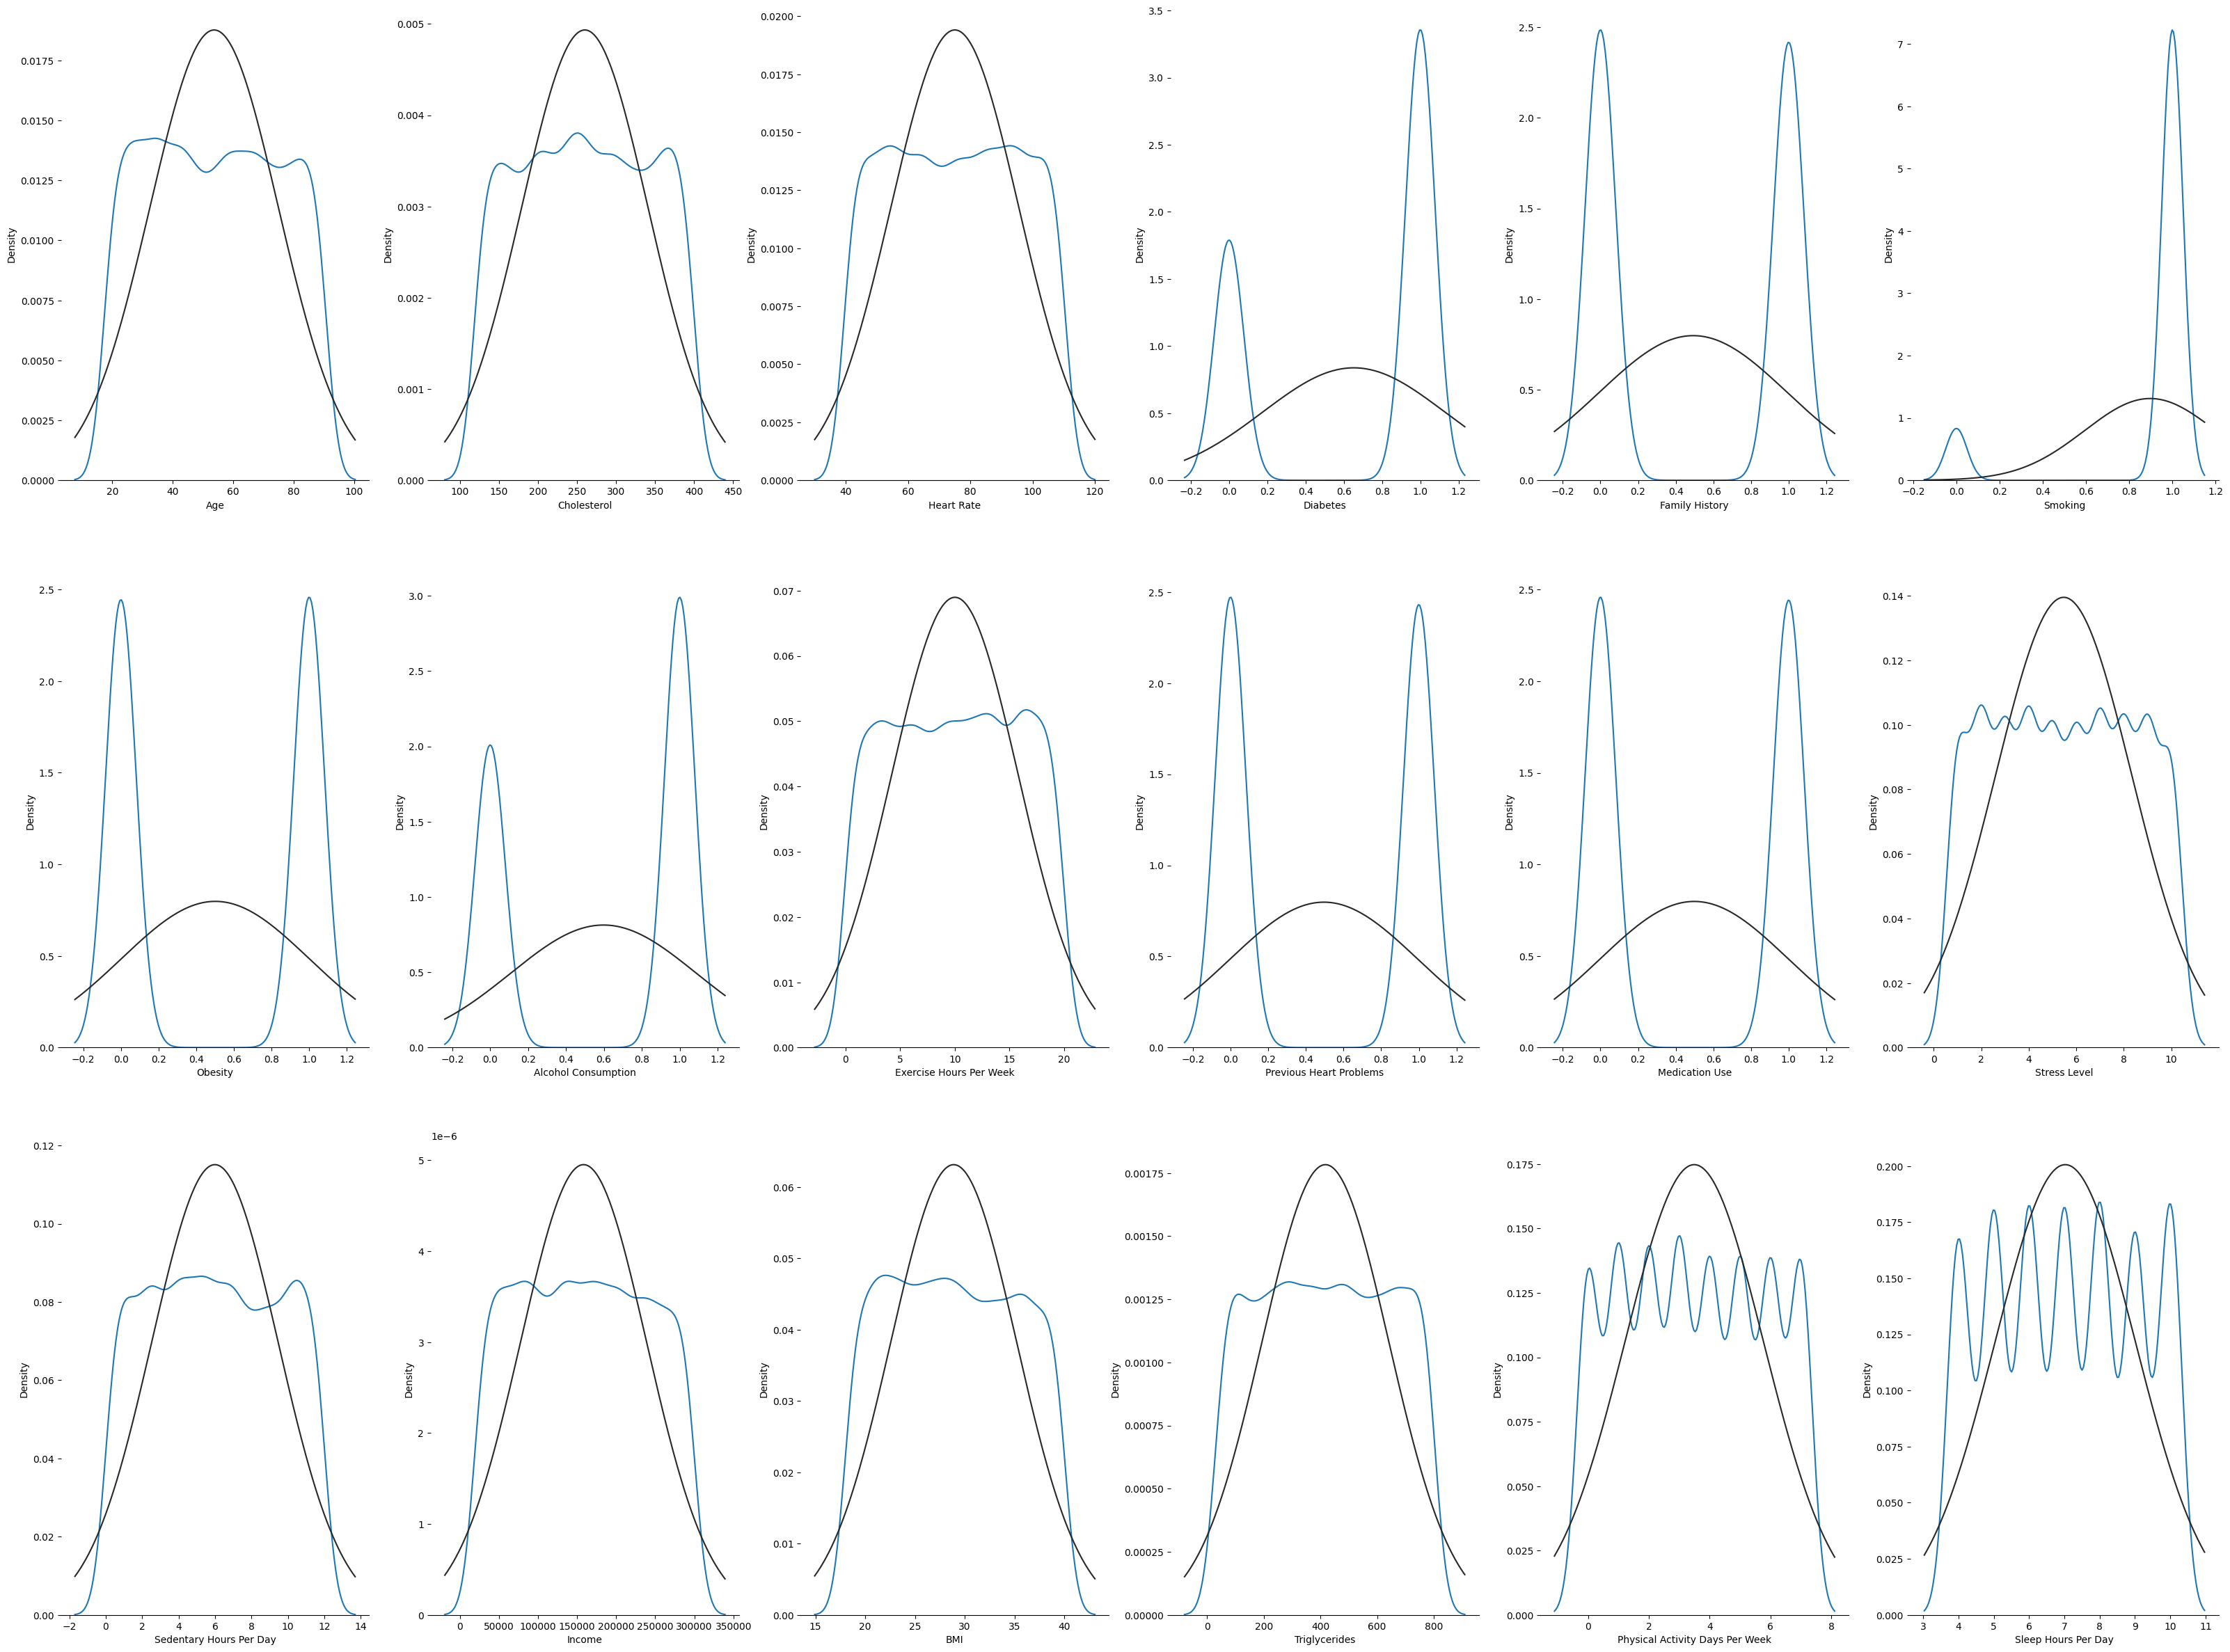

In [133]:
f, axes = plt.subplots(3, 6, figsize=(40, 30))
sns.despine(left=True)
for i in range(0, len(columns)):
    sns.distplot(X[columns[i]], fit=norm, hist=False, ax=axes[i//6, i%6])

Графики эксцессы, ассиметрии. Синим отображён график распределения, чёрным отображено нормальное распределение.

Поиск числовых значений ассиметрии и эксцессы:

In [134]:
for i in range(0, len(columns)):
    print("Skewness and Kurtosis of " + columns[i] + " : %f , %f" % (data[columns[i]].skew(), data[columns[i]].kurt()))

Skewness and Kurtosis of Age : 0.028498 , -1.213755
Skewness and Kurtosis of Cholesterol : -0.000955 , -1.180246
Skewness and Kurtosis of Heart Rate : -0.003227 , -1.211180
Skewness and Kurtosis of Diabetes : -0.639647 , -1.591215
Skewness and Kurtosis of Family History : 0.028080 , -1.999668
Skewness and Kurtosis of Smoking : -2.609778 , 4.812041
Skewness and Kurtosis of Obesity : -0.005707 , -2.000424
Skewness and Kurtosis of Alcohol Consumption : -0.400174 , -1.840281
Skewness and Kurtosis of Exercise Hours Per Week : -0.016387 , -1.203342
Skewness and Kurtosis of Previous Heart Problems : 0.016664 , -2.000179
Skewness and Kurtosis of Medication Use : 0.006620 , -2.000413
Skewness and Kurtosis of Stress Level : 0.008389 , -1.225439
Skewness and Kurtosis of Sedentary Hours Per Day : 0.017974 , -1.193479
Skewness and Kurtosis of Income : 0.021792 , -1.181923
Skewness and Kurtosis of BMI : 0.035996 , -1.187977
Skewness and Kurtosis of Triglycerides : -0.001915 , -1.197800
Skewness and 

Вычисление доверительных интервалов:

In [135]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [136]:
for i in range(0, len(columns)):
    m, mMinus, mPlus = mean_confidence_interval(X[columns[i]], confidence=0.95)
    print("Доверительный интервал для " + columns[i] + ": Среднее: %f с интервалом (%f , %f)" % (m, mMinus, mPlus))

Доверительный интервал для Age: Среднее: 53.707977 с интервалом (53.263007 , 54.152947)
Доверительный интервал для Cholesterol: Среднее: 259.877211 с интервалом (258.183914 , 261.570508)
Доверительный интервал для Heart Rate: Среднее: 75.021682 с интервалом (74.591340 , 75.452024)
Доверительный интервал для Diabetes: Среднее: 0.652288 с интервалом (0.642315 , 0.662261)
Доверительный интервал для Family History: Среднее: 0.492982 с интервалом (0.482512 , 0.503452)
Доверительный интервал для Smoking: Среднее: 0.896839 с интервалом (0.890469 , 0.903209)
Доверительный интервал для Obesity: Среднее: 0.501426 с интервалом (0.490956 , 0.511897)
Доверительный интервал для Alcohol Consumption: Среднее: 0.598083 с интервалом (0.587816 , 0.608350)
Доверительный интервал для Exercise Hours Per Week: Среднее: 10.014284 с интервалом (9.893171 , 10.135397)
Доверительный интервал для Previous Heart Problems: Среднее: 0.495835 с интервалом (0.485364 , 0.506305)
Доверительный интервал для Medication Use

## 4. Оценка нормальности распределения ИСД (их подчинения нормальному закону);

**Оценка нормальности распределения с помощью функции normaltest.**

In [137]:
for i in range(0, len(columns)):
    stat, p = normaltest(X[columns[i]])
    print('Оценка нормальности распределения для ' + columns[i] + '. Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Подчиняется нормальному закону распределения')
    else:
        print('Не подчиняется нормальному закону распределения')
    print()

Оценка нормальности распределения для Age. Statistics=8658.779, p=0.000
Не подчиняется нормальному закону распределения

Оценка нормальности распределения для Cholesterol. Statistics=6397.079, p=0.000
Не подчиняется нормальному закону распределения

Оценка нормальности распределения для Heart Rate. Statistics=8442.272, p=0.000
Не подчиняется нормальному закону распределения

Оценка нормальности распределения для Diabetes. Statistics=44733.204, p=0.000
Не подчиняется нормальному закону распределения

Оценка нормальности распределения для Family History. Statistics=30202.186, p=0.000
Не подчиняется нормальному закону распределения

Оценка нормальности распределения для Smoking. Statistics=4384.291, p=0.000
Не подчиняется нормальному закону распределения

Оценка нормальности распределения для Obesity. Statistics=30188.265, p=0.000
Не подчиняется нормальному закону распределения

Оценка нормальности распределения для Alcohol Consumption. Statistics=33744.889, p=0.000
Не подчиняется нормаль

**Видим, что данные не подчиняются нормальному распределнию**

## 6. Вычисление парных коэффициентов линейной корреляции.

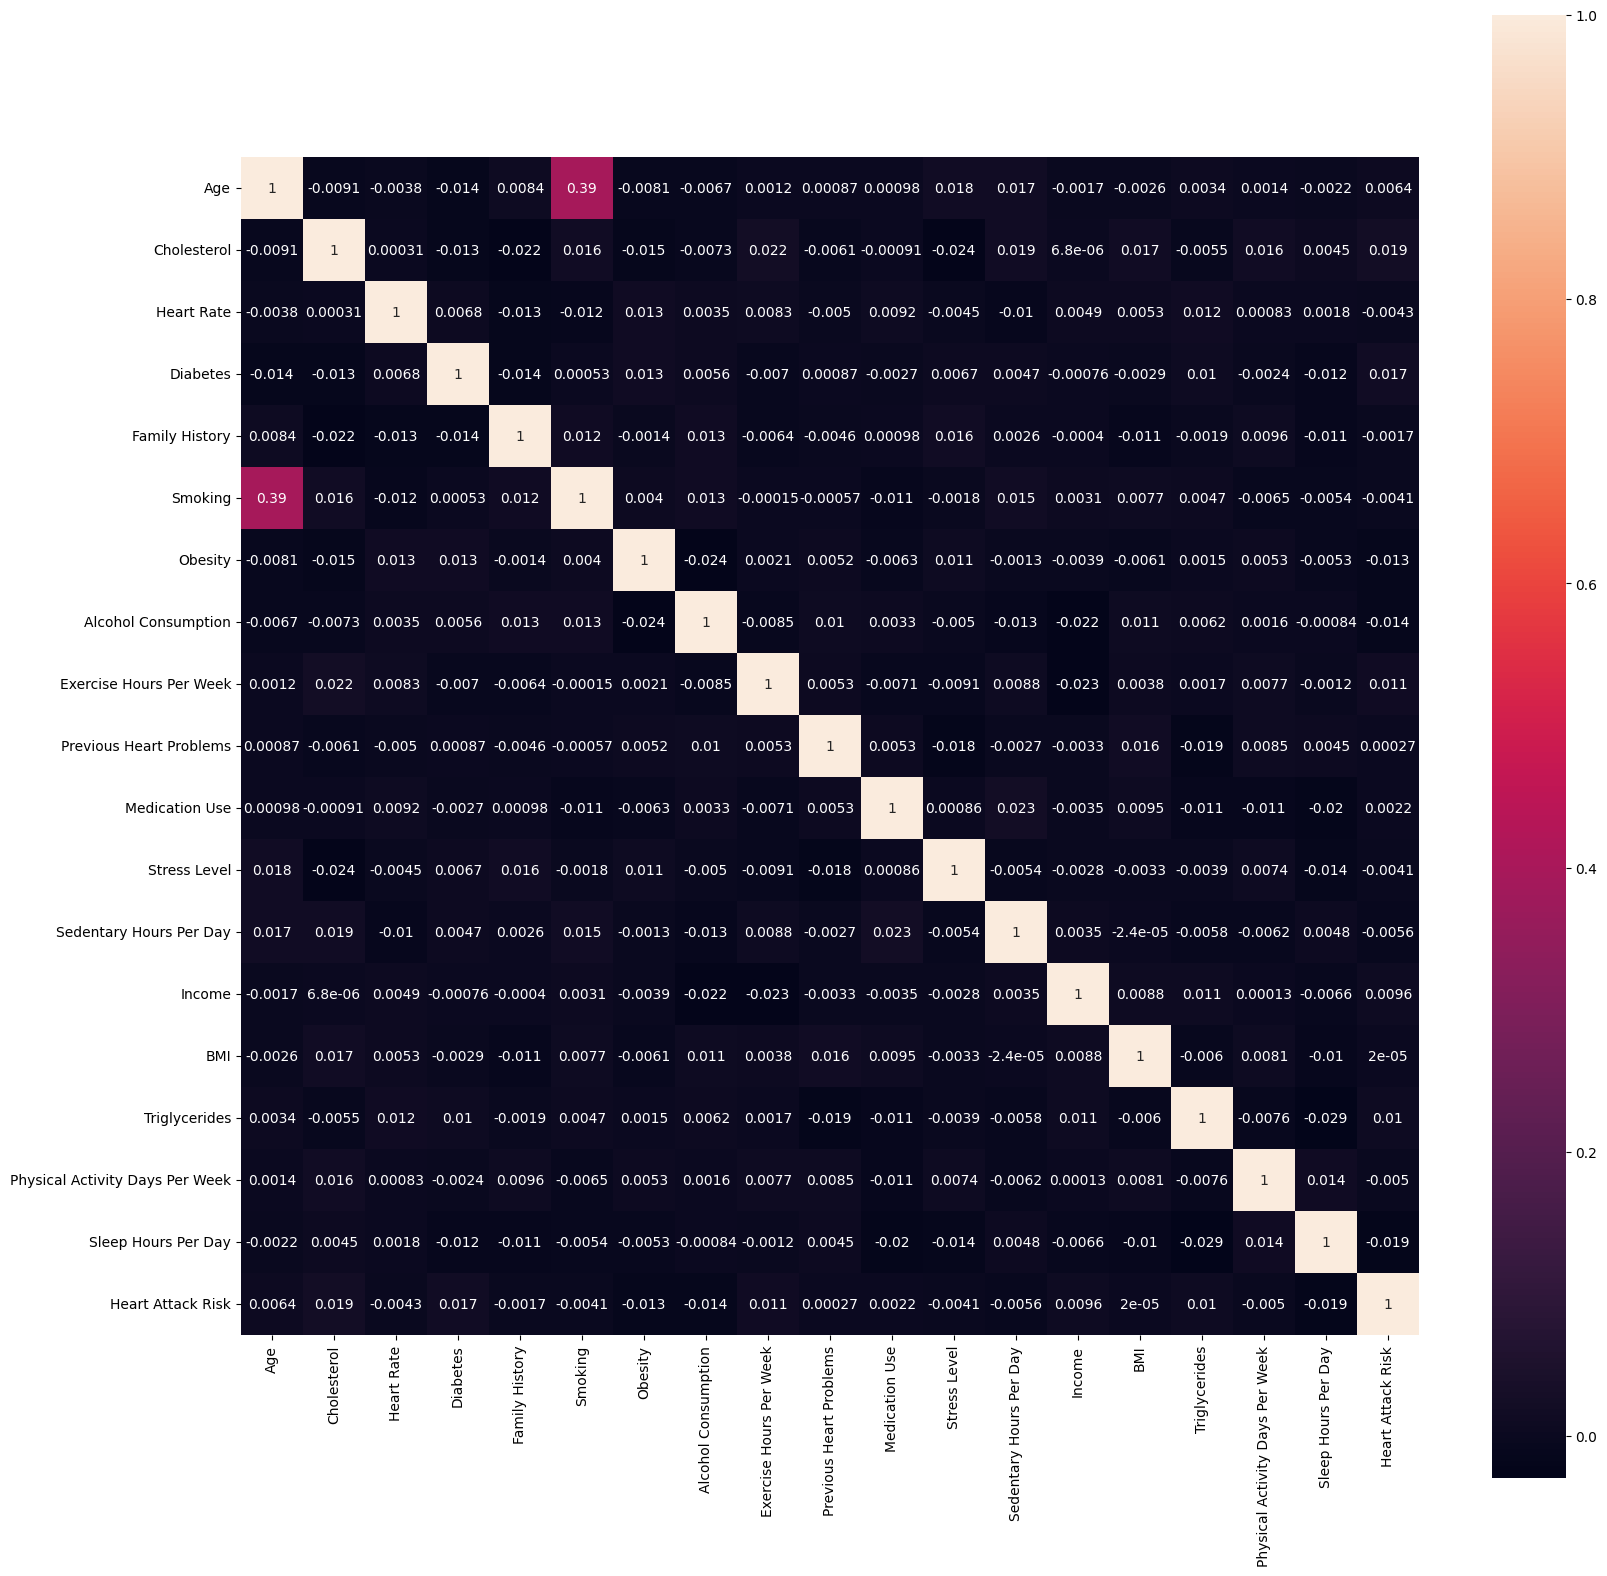

In [142]:
corr_data = data[X.columns.append(Y.columns)]
corrmat = corr_data.corr()
f, ax = plt.subplots(figsize=(19, 19))
sns.heatmap(corrmat, square=True, annot = True);

**Из полученной визуализации карты коррлеции делаем следующие выводы:**
1. Показатель ***Pregnacies*** (Беременность) слабо коррелирует с большинством показателей, кроме ***Age*** (возраст)
2. Показатель ***Glucose*** (Уровень глюкозы) имеет сильную (относительно других показателей) связь с показателем ***Outcome*** (Исход)
3. На показатель ***Outcome*** (Исход) сильнее всего влияют показатели: ***Glucose*** (Уровень глюкозы) ***BMI*** (индекс массы тела) ***Age*** (возраст) ***Pregnacies*** (Беременность). Кроме этого стоит учитывать, что ***Pregnacies*** и ***Age*** имеют взаимный высокий показатель корреляции
4. Наивысший показатель обратной корреляции у ***Age*** и ***SkinThickness*** (толщина кожи)


***Корреляционный анализ:***
Будем отбирать факторы с помощью функции stats.pearsonr.

Функция возвращает коэффицент корреляции(Изображён выше) и уровень значимости. Уровень значимостио отвечает за вероятность гипотезы о том, что наша корреляция "случайна". Если уровень значимости меньше чем наша переменная alpha, то можно отбросить эту гипотезу и принять данный фактор.

Корреляционный анализ для ***Pregnacies***:

In [ ]:
alpha = 0.05

In [ ]:
corr_y3_factors = np.zeros((8, 1), dtype=bool)
for i in range(0, np.shape(X)[1]):
    if(stats.pearsonr(Y.iloc[:, 0], X.iloc[:, i])[1]<alpha):
        corr_y3_factors[i] = True
    else:
        corr_y3_factors[i] = False
print(np.where(corr_y3_factors)[0])

### 7. Методы отбора признаков (используя различные критерии: BIC, AIC, среднеквадратическое отклонение)
Цель отбора признаков - это повысить вычислительную эффективность и убрать ошибки обобщения модели за счет удаления ненужных особенностей или шума.

Sequential Forward Selection (SFS) алгоритм.

Алгоритм последовательного прямого выбора (SFS) - это процедура восходящего поиска, которая начинается с пустого набора и постепенно добавляет признаки,
выбранные некоторой функцией оценки. При каждой итерации признак, который должен быть включен в набор признаков, 
выбирается среди оставшихся доступных признаков набора признаков, которые не были добавлены в набор признаков. 
Таким образом, новый расширенный набор признаков должен приводить к минимальной классификационной ошибке по сравнению с добавлением любой другой функции. 
SFS широко используется из-за их простоты и скорости

In [ ]:
from sklearn.linear_model import LinearRegression
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# Build step forward feature selection
sfs1 = sfs(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=None)
sfs2 = sfs(clf,
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=None)

# Perform SFFS
sfsY3 = sfs1.fit(X, Y.iloc[:, 2])
sfsY2 = sfs2.fit(X, Y.iloc[:, 1])
sfsY1 = sfs2.fit(X, Y.iloc[:, 0])